In [2]:
## Extract files

import os
from zipfile import ZipFile

if 'train.csv' not in os.listdir():
    ZipFile('titanic.zip','r').extractall()

In [3]:
## Load data

import pandas as pd

df_train = pd.read_csv('train.csv')
print(df_train.head(10))
print(df_train.info())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54

In [4]:
## Create validation set

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df_train.loc[:, df_train.columns != 'Survived'],df_train['Survived'], test_size=0.2, random_state=42, stratify=df_train['Survived'])

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


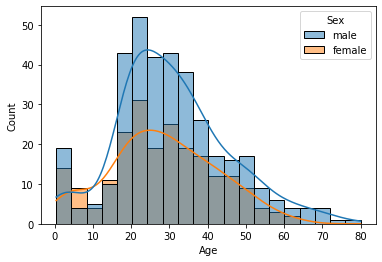

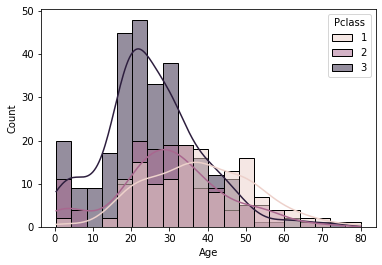

In [5]:
## Check null values

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.figure()
print(sns.histplot(data=X_train,x='Age',kde=True, bins=20,hue='Sex'))
plt.figure()
print(sns.histplot(data=X_train,x='Age',kde=True, bins=20,hue='Pclass'))

In [13]:
## Estimate Age

def get_titles(row):
    return row['Name'].split(', ')[1].split('.')[0]

X_train['Titles'] = X_train.apply(get_titles, axis=1)

In [18]:
## Transformation pipeline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier

class CombinedAttributesAdder(BaseEstimator, TransformerMixin): 
    def fit(self, X, y = None):
        return self # nothing else to do 
    def transform(self, X):
        X[:,1] = X[:,1]*0
        return X

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ("one_hot_enconder", OneHotEncoder())
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, ['PassengerId','Age','SibSp','Parch','Fare']),
    # ("cat", cat_pipeline, ['Sex','Pclass','Cabin','Embarked']),
    ("cat", cat_pipeline, ['Sex']),
])

model = Pipeline([
    ('preprocesing', full_pipeline),
    ('rfc',RandomForestClassifier(n_jobs =-1))
])

# model = model.fit(X_train[['PassengerId','Age','SibSp','Parch','Fare','Sex']],y_train)


In [31]:
## Fine tuning: Grid Search

from sklearn.model_selection import GridSearchCV
import numpy as np

# for param in model.get_params().keys():
#     print(param)

param_grid = [{ 
    "rfc__n_estimators": [100, 200, 500], 
    "rfc__max_leaf_nodes": [8, 16]
    }] 

grid_search = GridSearchCV( model, param_grid, cv = 3) 
grid_search.fit(X_train[['PassengerId','Age','SibSp','Parch','Fare','Sex']], y_train)

grid_search.best_params_

{'rfc__max_leaf_nodes': 8, 'rfc__n_estimators': 500}

In [32]:
## Evaluate on validation data

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score

model = grid_search.best_estimator_

predictions = model.predict(X_val[['PassengerId','Age','SibSp','Parch','Fare','Sex']])
print(confusion_matrix(y_val, predictions))
print(precision_score(y_val, predictions))
print(recall_score(y_val, predictions))
print(f1_score(y_val, predictions))


[[99 11]
 [25 44]]
0.8
0.6376811594202898
0.7096774193548386
